## 1. Setup
Install dependencies and clone TensorFlow Object Detection API

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install ensemble-boxes==1.0.6

In [3]:
!pip install -U tf2onnx==1.9.1

In [4]:
!pip install nnoir-onnx==1.0.13

In [5]:
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt

--2021-08-21 10:15:28--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco-labels-paper.txt.1’

coco-labels-paper.t 100%[===================>]     702  --.-KB/s    in 0s      

2021-08-21 10:15:28 (25.5 MB/s) - ‘coco-labels-paper.txt.1’ saved [702/702]



In [6]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2021-08-21 10:15:28--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.125.128, 2404:6800:4008:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.125.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.1’

ssd_mobilenet_v1_co 100%[===================>]  73.00M  68.0MB/s    in 1.1s    

2021-08-21 10:15:30 (68.0 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.1’ saved [76541073/76541073]



In [7]:
!tar xvf /content/ssd_mobilenet_v1_coco_2018_01_28.tar.gz

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.meta
ssd_mobilenet_v1_coco_2018_01_28/saved_model/
ssd_mobilenet_v1_coco_2018_01_28/saved_model/saved_model.pb
ssd_mobilenet_v1_coco_2018_01_28/saved_model/variables/
ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb


In [8]:
!git clone https://github.com/tensorflow/models.git
%cd models/
!git checkout 0ea84d6df6220552cd5229a0181c9e420f815408

fatal: destination path 'models' already exists and is not an empty directory.
/content/models
HEAD is now at 0ea84d6d Changing the default number of channels for lighter-weight hourglass backbones.


In [9]:
import os
import math
import subprocess
import onnx
import numpy as np
import tensorflow as tf
import cv2
import nnoir
from collections import namedtuple
from PIL import Image, ImageDraw, ImageFont
from ensemble_boxes import *

In [10]:
%cd /content/models/research 

/content/models/research


In [11]:
!apt --quiet update
!apt install --quiet protobuf-compiler

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [12]:
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf1/setup.py .
!python3 -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1628540 sha256=79d0c2b1556b3b9d37c22c1b36e701afd6a6fb97a3e21c330c4e8badefae7e3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-b82xh3ou/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [13]:
!python3 object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.7.11: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_w

## 2. Create TensorFlow Lite Model
- comment out batch_norm_trainable: true in pileline.config
- set add_postprocessing_op=False

In [14]:
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path="/content/ssd_mobilenet_v1_coco_2018_01_28/pipeline.config" \
--trained_checkpoint_prefix="/content/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt" \
--output_directory=/content \
--add_postprocessing_op=False

Instructions for updating:
Please use `layer.__call__` method instead.
W0821 10:15:53.920132 139745601120128 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0821 10:15:55.855949 139745601120128 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0821 10:15:55.895217 139745601120128 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0821 10:15:55.933294 139745601120128 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [15]:
!tflite_convert \
--graph_def_file=/content/tflite_graph.pb \
--output_file=/content/ssd_mobilenet_v1.tflite \
--input_format=TENSORFLOW_GRAPHDEF \
--output_format=TFLITE \
--inference_type=FLOAT \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays=raw_outputs/box_encodings,raw_outputs/class_predictions

2021-08-21 10:16:00.958911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-21 10:16:00.970343: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-21 10:16:00.970400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ef09eb4fba7f): /proc/driver/nvidia/version does not exist
2021-08-21 10:16:00.976061: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-08-21 10:16:00.976340: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564141d72a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-21 10:16:00.976380: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-21 10:16:01.213215: I tensorflow/core/grappler/de

## 3. Create anchor 
- https://qiita.com/PINTO/items/1312d308b553362a8ebf#%EF%BC%96appendix

In [16]:
from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_util

GRAPH_PB_PATH = '/content/tflite_graph.pb'

with tf.Session() as sess:
  with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    wts = [n for n in graph_nodes if n.op=='Const']
    for n in wts:
        if n.name == 'anchors':
            print("Name of the node - %s" % n.name)
            print("Value - ")
            anchors = tensor_util.MakeNdarray(n.attr['value'].tensor)
            print("anchors.shape =", anchors.shape)
            print(anchors)
            np.save('/content/anchors.npy', anchors)
            np.savetxt('/content/anchors.csv', anchors, delimiter=',')
            break

Instructions for updating:
Use tf.gfile.GFile.
Name of the node - anchors
Value - 
anchors.shape = (1917, 4)
[[0.02631579 0.02631579 0.1        0.1       ]
 [0.02631579 0.02631579 0.14142136 0.28284273]
 [0.02631579 0.02631579 0.28284273 0.14142136]
 ...
 [0.5        0.5        0.5484828  1.6454482 ]
 [0.5        0.5        1.6455305  0.54845536]
 [0.5        0.5        0.97467947 0.97467947]]


https://github.com/ChrystleMyrnaLobo/tflite-object-detection/blob/master/inference.py

## 4. Convert TensorFlow Lite Model to ONNX

In [17]:
!python -m tf2onnx.convert --tflite /content/ssd_mobilenet_v1.tflite \
 --output /content/ssd_mobilenet_v1.onnx --opset 14

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))

2021-08-21 10:16:07,309 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2021-08-21 10:16:07,311 - INFO - Using tensorflow=1.15.2, onnx=1.10.1, tf2onnx=1.9.1/8e8c23
2021-08-21 10:16:07,311 - INFO - Using opset <onnx, 14>
2021-08-21 10:16:07,703 - INFO - Optimizing ONNX model
2021-08-21 10:16:08,917 - INFO - After optimization: Cast -13 (13->0), Const -91 (190->99), Identity -2 (2->0), Reshape -13 (26->13), Transpose -177 (188->11)
2021-08-21 10:16:08,974 - INFO - 
2021-08-21 10:16:08,974 - INFO - Successfully converted TensorFlow model /content/ssd_mobilenet_v1.tflite to ONNX
2021-08-21 10:16:08,975 - INFO - M

In [18]:
onnx_model = onnx.load("/content/ssd_mobilenet_v1.onnx")
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid.')

The model is valid.


In [19]:
onnx_model_output =[node.name for node in onnx_model.graph.output]
print(onnx_model_output)

['raw_outputs/box_encodings', 'raw_outputs/class_predictions']


In [20]:
input_all = [node.name for node in onnx_model.graph.input]
input_initializer =  [node.name for node in onnx_model.graph.initializer]
net_feed_input = list(set(input_all)  - set(input_initializer))

print(net_feed_input)

['normalized_input_image_tensor']


## 5. Convert ONNX Model to nnoir

In [21]:
!onnx2nnoir -o /content/ssd_mobilenet_v1.nnoir /content/ssd_mobilenet_v1.onnx --graph_name ssd_mobilenet_v1

In [22]:
nnoir_model = nnoir.load('/content/ssd_mobilenet_v1.nnoir')

In [23]:
def normalize(img):
    img = np.asarray(img, dtype='float32')
    img /= 255.0
    img -= 0.5
    img *= 2
    return img

In [24]:
PATH_TO_IMAGE = "/content/models/research/object_detection/test_images/image1.jpg"

In [25]:
img = cv2.imread(PATH_TO_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (300, 300), interpolation=cv2.INTER_LINEAR)
img = normalize(img)
img = np.expand_dims(img, axis=0)

## 6. nnoir Inference

In [26]:
box_encodings, class_predictions = nnoir_model.run(img.astype("float32"))

In [27]:
print(box_encodings)

[[[ 1.1904551  -0.10541388 -1.3780423  -4.923649  ]
  [ 1.3940011   1.5008283  -1.2539694  -2.1009414 ]
  [ 1.6997185   0.7246896  -1.1717077  -3.5706995 ]
  ...
  [-0.09599841  0.11533774  0.8175785  -2.5838978 ]
  [-0.11055144  0.06072515 -2.6621718   1.0383825 ]
  [-0.13393761  1.6855755  -0.4163374  -2.2667189 ]]]


In [28]:
print(class_predictions)

[[[9.29678917e-01 1.05406642e-02 1.96874142e-04 ... 1.74957514e-03
   4.39882278e-05 3.25232744e-04]
  [9.48985815e-01 1.22854412e-02 2.63065100e-04 ... 1.81493163e-03
   1.58905983e-04 2.00212002e-04]
  [9.51882303e-01 1.26258433e-02 3.03000212e-04 ... 1.51938200e-03
   8.82446766e-05 1.24633312e-04]
  ...
  [9.77083325e-01 2.64391303e-03 4.62859869e-04 ... 7.91460276e-04
   2.25186348e-04 2.63661146e-04]
  [9.76827383e-01 3.65158916e-03 4.74840403e-04 ... 5.21481037e-04
   1.85996294e-04 2.29805708e-04]
  [2.23934680e-01 2.59325504e-02 1.06066465e-04 ... 9.22799110e-04
   3.27825546e-05 3.80575657e-05]]]


In [29]:
labels = np.array([], dtype=int)
result_labels = np.append(labels, np.argmax(class_predictions[0], axis=1))

In [30]:
# Get Indexes that predict something other than background.
indexes_not_background = np.where(result_labels!=0)

In [31]:
indexes_not_background

(array([1271, 1331, 1333, 1391, 1393, 1745, 1747, 1761, 1763, 1766, 1796,
        1853, 1855, 1862, 1863, 1865, 1868, 1907, 1911, 1916]),)

In [32]:
len(indexes_not_background[0])

20

In [33]:
labels_not_background = np.take(result_labels, indexes_not_background)

In [34]:
scores = []
scores.append(list(map(max, class_predictions[0])))
scores_not_background = np.take(scores[0], indexes_not_background)

In [35]:
# from pipeline.config
y_scale = 10.0
x_scale = 10.0
h_scale = 5.0
w_scale = 5.0

# tensorflow/tensorflow/lite/detection_postprocess.cc
def decode_box_encodings(box_encoding, anchors, num_boxes):
    decoded_boxes = np.zeros((num_boxes, 4), dtype=np.float32)
    for i in range(num_boxes):
        ycenter = box_encoding[i][0] / y_scale * anchors[i][2] + anchors[i][0]
        xcenter = box_encoding[i][1] / x_scale * anchors[i][3] + anchors[i][1]
        half_h = 0.5 * math.exp((box_encoding[i][2] / h_scale)) * anchors[i][2]
        half_w = 0.5 * math.exp((box_encoding[i][3] / w_scale)) * anchors[i][3]
        decoded_boxes[i][0] = (xcenter - half_w) # xmin 
        decoded_boxes[i][1] = (ycenter - half_h) # ymin
        decoded_boxes[i][2] = (xcenter + half_w) # xmax
        decoded_boxes[i][3] = (ycenter + half_h) # ymax
    return decoded_boxes

In [36]:
anchors = np.load('/content/anchors.npy')
box_decoded = decode_box_encodings(box_encodings[0], anchors, 1917)
box_not_background = np.take(box_decoded, indexes_not_background, axis=0)
box_clipped = box_not_background.clip(0, 1)

In [37]:
nms_boxes, nms_scores, nms_labels = nms(box_clipped.tolist(), scores_not_background.tolist(), labels_not_background.tolist(), iou_thr=0.5)

In [38]:
coco_labels = ['background']
with open("/content/coco-labels-paper.txt",'r') as f:
  for line in f:
    coco_labels.append(line.rstrip())

In [39]:
img.shape

(1, 300, 300, 3)

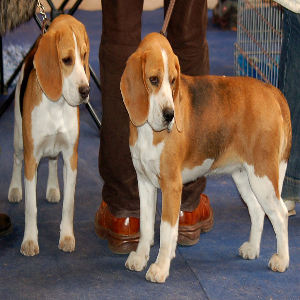

In [40]:
image = cv2.imread(PATH_TO_IMAGE)
image = cv2.resize(image, (300, 300))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)
image_pil

In [41]:
coco_labels_length = len(coco_labels)
draw = ImageDraw.Draw(image_pil)
for box, score , label in zip(nms_boxes, nms_scores, nms_labels):
  if score> 0.5 and label > 0 and label < coco_labels_length:
    xmin = box[0]*300
    ymin = box[1]*300
    xmax = box[2]*300
    ymax = box[3]*300
    draw.rectangle((xmin, ymin, xmax, ymax), outline=(0, 0, 255), width=2)
    draw.text([xmin+2, ymin+2], text=coco_labels[label])

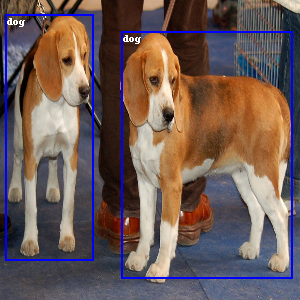

In [42]:
image_pil